In [ ]:
from collections import defaultdict
from itertools import count
import matplotlib.pyplot as plt
from metaphone import doublemetaphone
import pandas as pd
from statistics import mean
import textdistance
import os
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_predict, cross_validate, StratifiedKFold

# Load Data

Load your folds in the following cell:

In [ ]:
dir_name = "../results/random_emb25_lay8"

folds = []

for i in range(5):
  test_csv = os.path.join(dir_name, f"test_k{i}.csv")
  df = pd.read_csv(test_csv, usecols=["name1", "name2", "label"])
  df = df.astype({"label": bool, "name1": str, "name2": str})
  df = df.rename(columns={"name1": "name_a", "name2": "name_b"})

  folds.append(df)

Loads data from the 1871/1878 dataset

Once your folds are loaded, the output of the following commands should look roughly like this:

In [ ]:
len(folds)

5

In [ ]:
folds[0]

,name_a,name_b,label
0,maynes,swearer,False
1,fander,seimiller,False
2,buum,breum,True
3,liebergen,lebergen,True
4,rancier,ransier,True
...,...,...,...
9995,harman,harmon,True
9996,grinyer,gringer,True
9997,boatfield,boartfield,True
9998,shinabargar,shinabarger,True


# Generate Features

In [ ]:
def compare_dm1(s1, s2):
    return textdistance.levenshtein.normalized_similarity(doublemetaphone(s1)[0],doublemetaphone(s2)[0])

def compare_dm2(s1, s2):
    return textdistance.levenshtein.normalized_similarity(doublemetaphone(s1)[1],doublemetaphone(s2)[1])

In [ ]:
%%time
for pairs in folds:
    pairs['levenshtein'] = [textdistance.levenshtein.normalized_similarity(x, y) for x, y in pairs[['name_a', 'name_b']].itertuples(index=False)]
    pairs['jaro'] = [textdistance.jaro.normalized_similarity(x, y) for x, y in pairs[['name_a', 'name_b']].itertuples(index=False)]
    pairs['jaro_winkler'] = [textdistance.jaro_winkler.normalized_similarity(x, y) for x, y in pairs[['name_a', 'name_b']].itertuples(index=False)]
    pairs['jaccard'] = [textdistance.jaccard.normalized_similarity(x, y) for x, y in pairs[['name_a', 'name_b']].itertuples(index=False)]
    pairs['sorensen_dice'] = [textdistance.sorensen_dice.normalized_similarity(x, y) for x, y in pairs[['name_a', 'name_b']].itertuples(index=False)]
    pairs['dm1'] = [compare_dm1(x, y) for x, y in pairs[['name_a', 'name_b']].itertuples(index=False)]
    pairs['dm2'] = [compare_dm2(x, y) for x, y in pairs[['name_a', 'name_b']].itertuples(index=False)]

    pairs['vowels_a'] = pairs['name_a'].apply(lambda x: sum(map(x.count, 'aeiou')))
    pairs['vowels_b'] = pairs['name_b'].apply(lambda x: sum(map(x.count, 'aeiou')))
    pairs['consonants_a'] = pairs['name_a'].str.len() - pairs['vowels_a']
    pairs['consonants_b'] = pairs['name_b'].str.len() - pairs['vowels_b']
    pairs['vowels'] = (pairs['vowels_a'] - pairs['vowels_b']).abs()
    pairs['vowels'] = 1 - (pairs['vowels'] / pairs['vowels'].max())
    pairs['consonants'] = (pairs['consonants_a'] - pairs['consonants_b']).abs()
    pairs['consonants'] = 1 - (pairs['consonants'] / pairs['consonants'].max())
    pairs['characters'] = (pairs['name_a'].str.len() - pairs['name_b'].str.len()).abs()
    pairs['characters'] = 1 - (pairs['characters'] / pairs['characters'].max())
    pairs = pairs.drop(columns=['vowels_a', 'vowels_b', 'consonants_a', 'consonants_b'])

CPU times: user 24.9 s, sys: 928 ms, total: 25.8 s
Wall time: 24.5 s


# Classification

In [ ]:
%%time
scores = defaultdict(list)
y_prob = []

for test_fold_index in range(len(folds)):
    val_fold_index = test_fold_index - 1 if test_fold_index - 1 >= 0 else len(folds) - 1


    X_train = pd.DataFrame()
    y_train = pd.Series(dtype=bool)
    for fold_index in range(len(folds)):
        if fold_index != test_fold_index and fold_index != val_fold_index:
            X_train = pd.concat([X_train, folds[fold_index].drop(columns=['name_a', 'name_b', 'label'])])
            y_train = pd.concat([y_train, folds[fold_index]['label']])
    X_test = folds[test_fold_index].drop(columns=['name_a', 'name_b', 'label'])
    y_test = folds[test_fold_index]['label']
    
    clf = RandomForestClassifier(random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    scores['test_precision'].append(precision_score(y_test, y_pred))
    scores['test_recall'].append(recall_score(y_test, y_pred))
    scores['f1_score'].append(f1_score(y_test, y_pred))

    yt = np.array(y_test)
    yp = np.array(y_pred)

    scores['tp'].append(np.count_nonzero(yt & yp))
    scores['tn'].append(np.count_nonzero(np.logical_not(yt) & np.logical_not(yp)))
    scores['fp'].append(np.count_nonzero(np.logical_not(yt) & yp))
    scores['fn'].append(np.count_nonzero(yt & np.logical_not(yp)))

    y_prob += [x[1] for x in clf.predict_proba(X_test)]

print({k: mean(v) for k, v in scores.items()})

[False False  True ...  True  True  True]


NameError: ignored

## Precision Recall Curve

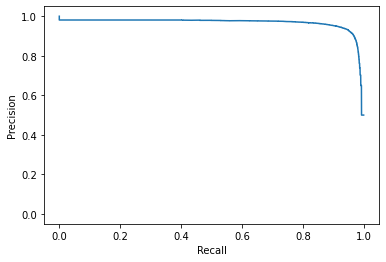

In [ ]:
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim((-0.05, 1.05))
plt.ylim((-0.05, 1.05))
precision, recall, _ = precision_recall_curve(pd.concat([fold['label'] for fold in folds]), y_prob)
plt.step(recall, precision, where='post')